## Basics of Convolution

In [1]:
!pip install -Uqq fastbook
import numpy as np
import fastbook
from fastbook import *
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Convolutions with images allows us to do feature engineering. 

This is the transformation of inputs into forms that are easier to train. 

Convolutions for instance allow us to take an image and transform the pixel inputs so that we can find were the edges are are. 

To do convolutions, we aapply a kernel (a matrix) across an image were we repeatedly do the operations of multiplications and addition. 

In [3]:
# create a kernel
top_edge = tensor([ # this detects horizontal edges that go from bright to dark 
    [-1, -1, -1], 
    [0, 0, 0],
    [1, 1, 1]
]).float()

<Axes: >

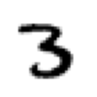

In [2]:
# use the MNIST sample for 3s and 7s 
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
im3 = Image.open(path/'train/3/12.png')
show_g = partial(show_image, cmap='gray_r')
show_g(im3)

In [24]:
im3_t = tensor(im3)
(im3_t[0:3, 0:3] * top_edge).sum()

tensor(0.)

In [26]:
im3_t.shape

torch.Size([28, 28])

<Axes: >

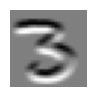

In [47]:
# apply the kernel for top edge detection
def apply_kernel(r, c, kernel):
    return (im3_t[r-1:r+2,c-1:c+2] * kernel).sum()

rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_g(top_edge3)

The image is darker where there are horizontal edges from light to dark. 
It is lighter where there are horizontal edges from dark to ligh

<Axes: >

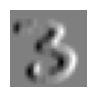

In [48]:
# do the same for left edges 
left_edge = tensor(
    [-1, 0, 1], 
    [-1, 0, 1],
    [-1, 0, 1]
)

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_g(left_edge3)

In [50]:
'''
Pytorch has a F.conv2d that does the above convolution.
Input is of shape (mini_batch, in_chann, H, W)
Kernel weights are (out_chann, in_chann, H, W)

Pytorch inputs have high ranks to utilize GPUs to do as
many ops as possible in parallel
'''

# lets test that 
diag1_edge = tensor([
    [0, -1, 1],
    [-1, 1, 0],
    [1, 0, 0]
]).float()

diag2_edge = tensor([
    [1, -1, 0],
    [0, 1, -1],
    [0, 0, 1]
]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [52]:
# add another rank to kernel weights to match pytorch
edge_kernels = edge_kernels.unsqueeze(1)
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [3]:
# get the batch data 
mnist = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label
)
dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [66]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

<Axes: >

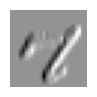

In [76]:
show_g(batch_features[0,0]) # left edge

## Conv Neural Net

In [12]:
'''
Use a stride of 2 while increasing features 
to decrease output size at end
'''
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

simple_cnn = sequential(
    conv(1,4), #14x14
    conv(4,8), #7*7
    conv(8,16), #4x4
    conv(16,32),#2x2
    conv(32, 2), #1x1
    Flatten()
)
xb_cpu = to_cpu(xb) # to prevent mismatches between data on cpu and other on gpu
simple_cnn(xb_cpu).shape
    

torch.Size([64, 2])

In [6]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [8]:
# learn w/ 2 epochs and 0.01 max learning rate
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.068651,0.050918,0.983808,00:22
1,0.019111,0.024231,0.993131,00:20


In [10]:
??learn.fit_one_cycle

Signature:
learn.fit_one_cycle(
    n_epoch,
    lr_max=None,
    div=25.0,
    div_final=100000.0,
    pct_start=0.25,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False, start_epoch=0):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
File:      /opt/conda/lib/python3.10/site-packages/fastai/callback/schedule.py
Type:      met